In [87]:
import sys
sys.path.append("../../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd

%matplotlib inline

plt.style.use(["science","bright","grid"])

In [91]:
time_step       = 1e-7
# radius          = 1000000.0
radius          = 10.0
eq_step         = 0
N_min, N_max    = 2, 12
N_vals          = np.arange(N_min, N_max)
path            = '/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/magnitude/'
data_string     = {N : pd.read_csv(f"{path}Nx={N}_Ny=1_Nz=1_Ne=2_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in N_vals}
data_network    = {N : pd.read_csv(f"{path}Nx={N}_Ny={N}_Nz=1_Ne=8_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in [3,5,7,9,11,13]}
states_string   = {N : pd.read_csv(f"{path}mean_state_Nx={N}_Ny=1_Nz=1_Ne=2_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in N_vals}
states_network  = {N : pd.read_csv(f"{path}mean_state_Nx={N}_Ny={N}_Nz=1_Ne=8_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in [3,5,7,9,11,13]}
t_vals          = np.arange(len(data_string[2]))*time_step*1e6
x_vals          = data_string[2]['E0'].values*1000

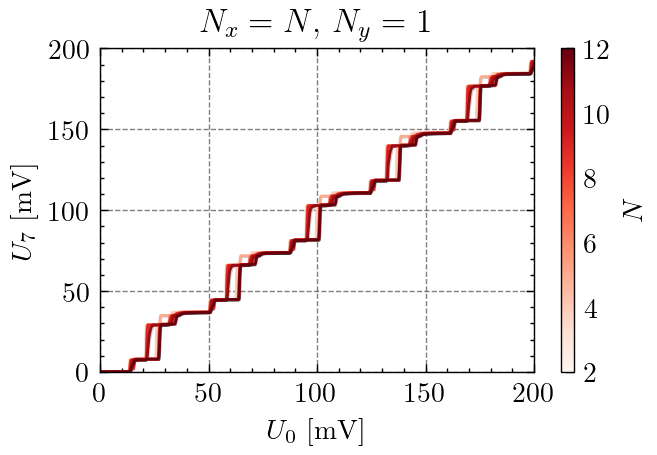

In [92]:
cmap    = plt.get_cmap("Reds")
fig, ax = plt.subplots(dpi=200)
fig.set_figheight(fig.get_figheight()*0.8)

for i, (key, df) in enumerate(data_string.items()):

    val     = df['Current'].values*1000
    val_e   = df['Error'].values*1000
    ax.plot(x_vals, val, c=cmap((i+1)/len(N_vals)))
    ax.fill_between(x_vals, val-val_e, val+val_e, color='black', alpha=0.2)

ax.set_xlabel("$U_0$ [mV]")
ax.set_ylabel("$U_7$ [mV]")
ax.set_xlim(0,200)
ax.set_ylim(0,200)
ax.set_title("$N_x = N$, $N_y = 1$")

norm    = mpl.colors.Normalize(vmin=N_min, vmax=N_max)
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig.colorbar(cbar, ax=ax, label='$N$', aspect=25)
fig.savefig(f"../plots/magnitude/input_output_string_radius_{radius}.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/magnitude/input_output_string_radius_{radius}.pdf", bbox_inches='tight', transparent=False)

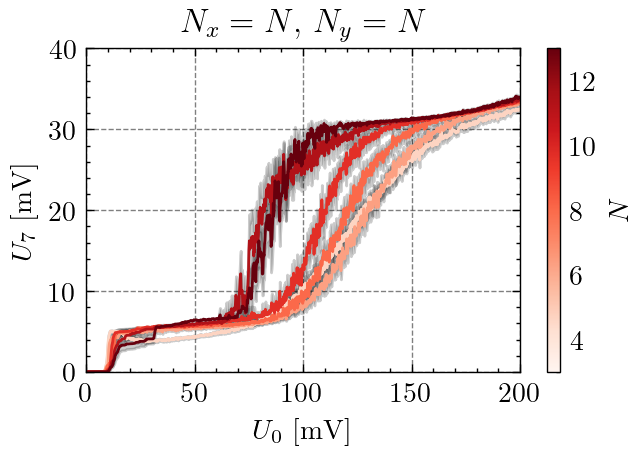

In [93]:
cmap    = plt.get_cmap("Reds")
fig, ax = plt.subplots(dpi=200)
fig.set_figheight(fig.get_figheight()*0.8)

for i, (key, df) in enumerate(data_network.items()):

    val     = df['Current'].values*1000
    val_e   = df['Error'].values*1000
    ax.plot(x_vals, val, c=cmap((i+1)/len(data_network.keys())))
    ax.fill_between(x_vals, val-val_e, val+val_e, color='black', alpha=0.2)

ax.set_xlabel("$U_0$ [mV]")
ax.set_ylabel("$U_7$ [mV]")
ax.set_xlim(0,200)
ax.set_ylim(0,40)
ax.set_title("$N_x = N$, $N_y = N$")

norm    = mpl.colors.Normalize(vmin=3, vmax=13)
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig.colorbar(cbar, ax=ax, label='$N$', aspect=25)
fig.savefig(f"../plots/magnitude/input_output_network_radius_{radius}.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/magnitude/input_output_network_radius_{radius}.pdf", bbox_inches='tight', transparent=False)